In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import pathlib

import vlbi

figsize = [10,7]

c = 299792458 # speed of light in m/s
fs = 40000

In [2]:
observation = np.dtype([('utc', np.float32), ('delta_range', np.float32), ('delta_velocity', np.float32), ('freq', np.float32), ('max_corr', np.float32)])

def compute_observation(data):
    time = data['time'][0] + 0.5*data['corr'].size/fs
    corr_peak = np.argmax(np.abs(data['corr']))
    corr_peak += vlbi.peak_estimator_parabola(np.abs(data['corr'][corr_peak-1:corr_peak+2]))
    delta_range = vlbi.delta_range(corr_peak, data['corr'].size, data['time'][0] - data['time'][1])
    delta_velocity =  -(data['freq_bin']*fs/data['corr'].size + data['f_lo'][0,0] - data['f_lo'][1,0]) * c / data['freq']
    return time, delta_range, delta_velocity, data['freq'], np.max(np.abs(data['corr']))

In [3]:
path = pathlib.Path('vlbi_20180610')

In [4]:
observations = np.fromiter((compute_observation(np.load(str(p))) for p in path.iterdir()), dtype=observation)
# filter by delta_range
observations = observations[np.abs(observations['delta_range']) < 10e6]

In [5]:
def range_doppler(tracking):
    return np.sqrt(np.sum(tracking[:,0:3]**2, axis=1))*1e3

In [6]:
trk = vlbi.load_doppler_file('VLBI_Doppler.txt')
delta_range = range_doppler(trk[:,1:]) - range_doppler(trk[:,7:])
delta_velocity = vlbi.range_rate(trk[:,1:]) - vlbi.range_rate(trk[:,7:])
utc = vlbi.mjd2unixtimestamp(trk[:,0])

In [7]:
obs_435 = observations[observations['freq'] == 435.4e6]
obs_436 = observations[observations['freq'] == 436.4e6]
start = np.min(observations['utc']) - 120
end = np.max(observations['utc']) + 120
trk_sel = (utc >= start) & (utc <= end)

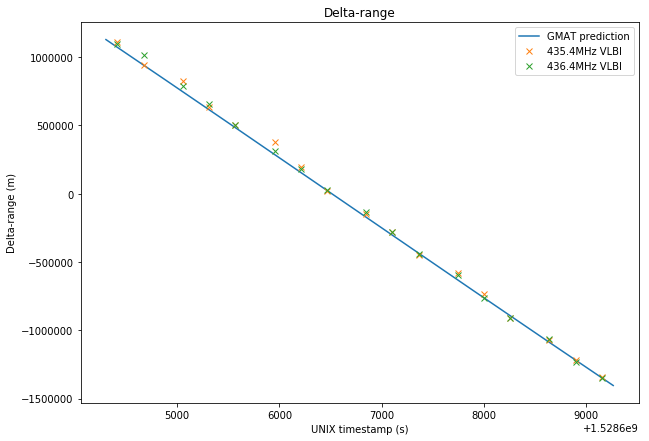

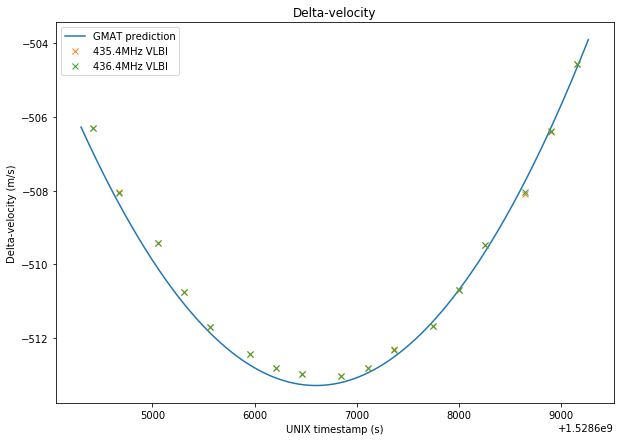

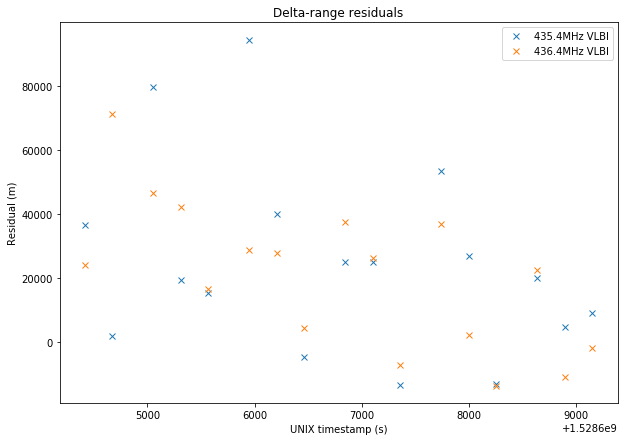

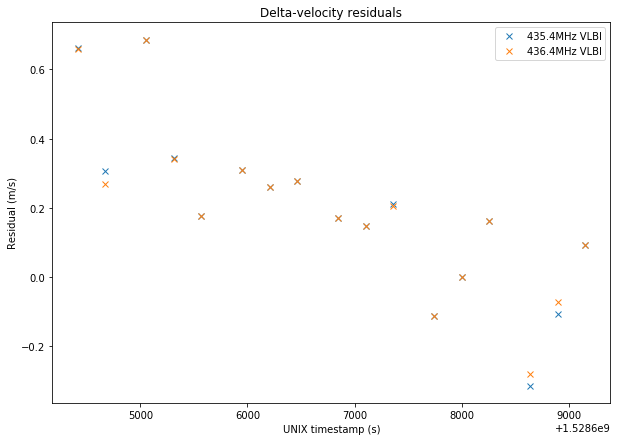

In [8]:
plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_range[trk_sel])
plt.plot(obs_435['utc'], obs_435['delta_range'], 'x')
plt.plot(obs_436['utc'], obs_436['delta_range'], 'x')
plt.title('Delta-range')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-range (m)')
plt.legend(['GMAT prediction', '435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(utc[trk_sel], delta_velocity[trk_sel])
plt.plot(obs_435['utc'], obs_435['delta_velocity'], 'x')
plt.plot(obs_436['utc'], obs_436['delta_velocity'], 'x')
plt.title('Delta-velocity')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Delta-velocity (m/s)')
plt.legend(['GMAT prediction', '435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['delta_range'] - np.interp(obs_435['utc'], utc, delta_range), 'x')
plt.plot(obs_436['utc'], obs_436['delta_range'] - np.interp(obs_436['utc'], utc, delta_range), 'x')
plt.title('Delta-range residuals')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Residual (m)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI'])
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['delta_velocity'] - np.interp(obs_435['utc'], utc, delta_velocity), 'x')
plt.plot(obs_436['utc'], obs_436['delta_velocity'] - np.interp(obs_436['utc'], utc, delta_velocity), 'x')
plt.title('Delta-velocity residuals')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Residual (m/s)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI']);

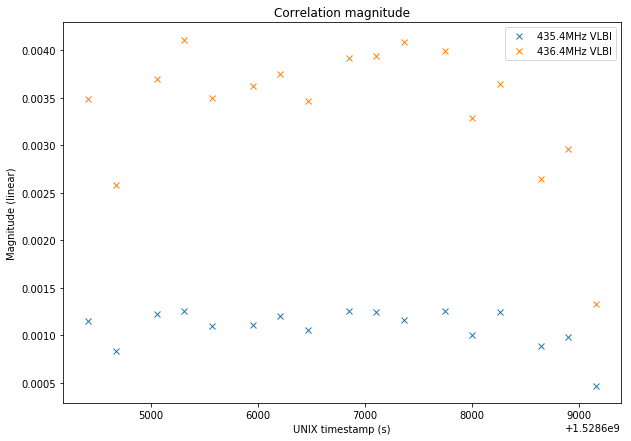

In [9]:
plt.figure(figsize=figsize, facecolor='w')
plt.plot(obs_435['utc'], obs_435['max_corr'], 'x')
plt.plot(obs_436['utc'], obs_436['max_corr'], 'x')
plt.title('Correlation magnitude')
plt.xlabel('UNIX timestamp (s)')
plt.ylabel('Magnitude (linear)')
plt.legend(['435.4MHz VLBI', '436.4MHz VLBI']);